## Colin's active development sandbox

In [1]:
from enum import Enum
from pathlib import Path
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
from tqdm.auto import tqdm
import os
import re
import cv2
from PIL import Image
import math
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import logging

from DataPreProcessing import DataPreProcessing, DataPaths
from DataAugmentation import DataAugmentation, LegalTransformations, ImageEnhancement

### Tracklet iterator

[2025-02-26 22:19:01] - [INFO]: DataPreProcessing initialized.
[2025-02-26 22:19:01] - [INFO]: ROOT_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted
[2025-02-26 22:19:01] - [INFO]: TRAIN_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\train\images
[2025-02-26 22:19:01] - [INFO]: TEST_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\test\images
[2025-02-26 22:19:01] - [INFO]: VAL_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\challenge\images
[2025-02-26 22:19:01] - [INFO]: Using device: cuda
[2025-02-26 22:19:01] - [INFO]: ['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005']
[2025-02-26 22:19:01] - [INFO]: Min tracklet: 0
[2025-02-26 22:19:01] - [INFO]: Max tracklet: 1426


Processing tracks:   0%|          | 0/1 [00:00<?, ?it/s]

dict_items([('rotation', <LegalTransformations.rotation: 40>), ('blur', <LegalTransformations.blur: 3>), ('brightness', <LegalTransformations.brightness: (0.7, 1.0)>), ('contrast', <LegalTransformations.brightness: (0.7, 1.0)>), ('stretch', <LegalTransformations.stretch: (0.7, 1.3)>), ('horizontal_flip', <LegalTransformations.horizontal_flip: True>)])


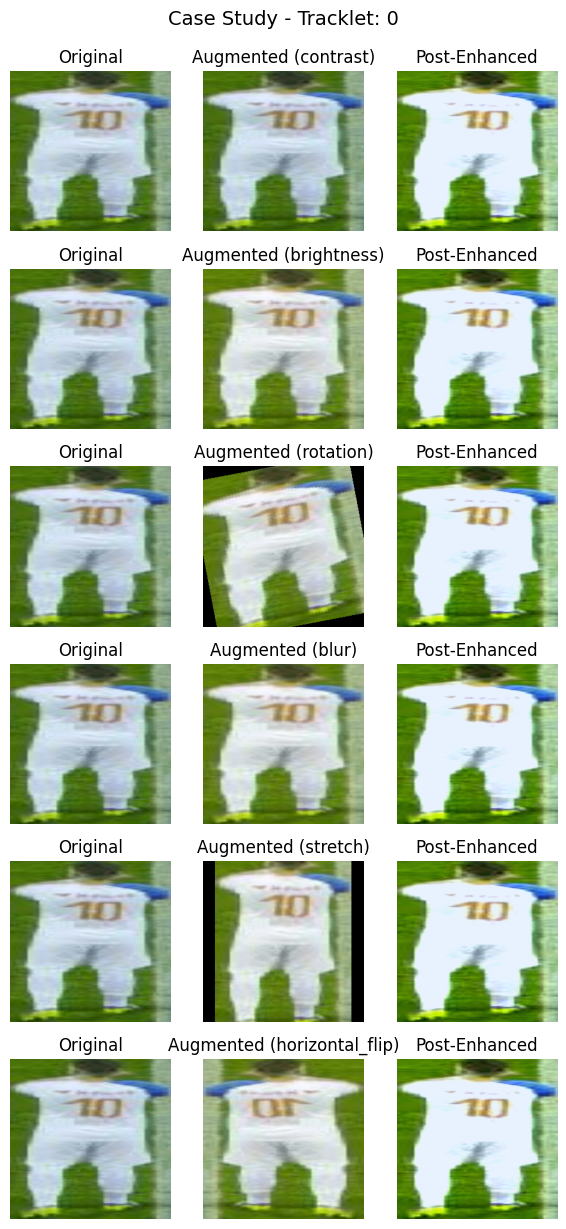

In [12]:
# Toggle case-study mode: if True, we display one image with multiple augmentation variants.
CASE_STUDY = True

input_folder = DataPaths.TRAIN_DATA_DIR.value

NUM_TRACKLETS = 1
NUM_IMGS_PER_TRACKLET = 1  # for case study, we assume one image per tracklet

# Instantiate the pre-processing class and load data
data_pre = DataPreProcessing()
data_dict = data_pre.generate_features(input_folder, DataPaths.TEMP_EXPERIMENT_DIR.value, num_tracks=NUM_TRACKLETS)

# Instantiate the augmentor and augment the data using specific transformations
augmentor = DataAugmentation(data_dict)
# Define the specific transformation array for the case study.
case_transformations = ["contrast", "brightness", "rotation", "blur", "stretch", "horizontal_flip"]
print(LegalTransformations.__members__.items())
enhance = ImageEnhancement()
augmented_data = augmentor.augment_data(case_transformations)
selected_tracks = list(data_dict.keys())[:NUM_TRACKLETS]

for track in selected_tracks:
    # Get original image (only one image per tracklet)
    orig_tensor = data_dict[track][:NUM_IMGS_PER_TRACKLET]  # shape: (N, C, H, W)
    
    # Enhance each image individually (enhance_image expects a 3D tensor)
    post_enhance_list = []
    for i in range(orig_tensor.shape[0]):
        enhanced = enhance.enhance_image(orig_tensor[i])
        post_enhance_list.append(enhanced)
    post_enhance_tensor = torch.stack(post_enhance_list)  # shape: (N, C, H, W)
    
    if CASE_STUDY:
        # For case study, each row corresponds to one transformation from our list.
        num_rows = len(case_transformations)
        # We expect only one image in the tracklet.
        # Get the augmentation dictionary for that single image.
        aug_dict = augmented_data[track][0]  
        
        # Prepare the original and post-enhanced images (they are the same across rows).
        orig_img = orig_tensor[0].permute(1, 2, 0).numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-6)
        post_img = post_enhance_tensor[0].permute(1, 2, 0).numpy()
        post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-6)
        
        fig, axs = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
        if num_rows == 1:
            axs = [axs]
        
        for idx, trans in enumerate(case_transformations):
            # For each transformation, retrieve the corresponding augmented image.
            if trans in aug_dict:
                aug_img_tensor = aug_dict[trans]
            else:
                aug_img_tensor = aug_dict["original"]
            
            aug_img = aug_img_tensor.permute(1, 2, 0).numpy()
            aug_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min() + 1e-6)
            
            axs[idx][0].imshow(orig_img)
            axs[idx][0].set_title("Original")
            axs[idx][0].axis("off")
            
            axs[idx][1].imshow(aug_img)
            axs[idx][1].set_title(f"Augmented ({trans})")
            axs[idx][1].axis("off")
            
            axs[idx][2].imshow(post_img)
            axs[idx][2].set_title("Post-Enhanced")
            axs[idx][2].axis("off")
        
        plt.tight_layout()
        plt.suptitle(f"Case Study - Tracklet: {track}", fontsize=14, y=1.02)
        plt.show()
    
    else:
        # Default behavior: each row corresponds to a different image.
        aug_list = augmented_data[track][:NUM_IMGS_PER_TRACKLET]
        num_images = orig_tensor.shape[0]
        
        fig, axs = plt.subplots(num_rows, 3, figsize=(6, num_rows))
        if num_images == 1:
            axs = [axs]
        
        for i in range(num_images):
            # Original image
            orig_img = orig_tensor[i].permute(1, 2, 0).numpy()
            orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-6)
            axs[i][0].imshow(orig_img)
            axs[i][0].set_title("Original")
            axs[i][0].axis("off")
            
            # Choose one augmented variant (priority order can be adjusted)
            aug_dict = aug_list[i]
            if "rotation" in aug_dict:
                aug_img_tensor = aug_dict["rotation"]
            elif "blur" in aug_dict:
                aug_img_tensor = aug_dict["blur"]
            elif "brightness" in aug_dict:
                aug_img_tensor = aug_dict["brightness"]
            elif "contrast" in aug_dict:
                aug_img_tensor = aug_dict["contrast"]
            elif "stretch" in aug_dict:
                aug_img_tensor = aug_dict["stretch"]
            elif "horizontal_flip" in aug_dict:
                aug_img_tensor = aug_dict["horizontal_flip"]
            else:
                aug_img_tensor = aug_dict["original"]
                
            aug_img = aug_img_tensor.permute(1, 2, 0).numpy()
            aug_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min() + 1e-6)
            axs[i][1].imshow(aug_img)
            axs[i][1].set_title("Augmented")
            axs[i][1].axis("off")
            
            # Post-enhanced image
            post_img_tensor = post_enhance_tensor[i]
            post_img = post_img_tensor.permute(1, 2, 0).numpy()
            post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-6)
            axs[i][2].imshow(post_img)
            axs[i][2].set_title("Post-Enhanced")
            axs[i][2].axis("off")
        
        plt.tight_layout()
        plt.suptitle(f"Tracklet: {track}", fontsize=14, y=1.02)
        plt.show()